Guided Project For Kaggle Fundementals

In [189]:
import pandas as pd
import re
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.model_selection import cross_val_score
import numpy as np
import seaborn as sns
%matplotlib inline


In [244]:

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

# %load functions.py
def process_missing(df):
    
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
   
    return df

def process_age(df):
    
    df["Age"] = df["Age"].fillna(np.mean(df["Age"]))
    cut_points = [-1,0,2,18,60,100]
    label_names = ["Missing","Infant","Child","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
   
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    
   
    return df

def create_dummies(df,column_name):
   
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df



In [245]:
def process_df(df):
    
    df = process_missing(df) 
    df = process_age(df)
    #df = process_fare(df) 
    df = process_titles(df) 
    df = process_cabin(df)
    df = create_dummies(df, "Age_categories")
    #df = create_dummies(df, "Fare_categories")
    df = create_dummies(df, "Title")
    df = create_dummies(df, "Cabin_type")
    df = create_dummies(df, "Sex")
    
    return df

In [246]:
# clean up the training and holdout datasets
train = process_df(train)
holdout = process_df(holdout)


<h1>Data Exploration</h1>

sibsp: # of siblings / spouses aboard the Titanic:
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

parch: # of parents / children aboard the Titanic
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.


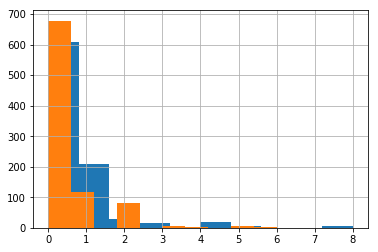

,SibSp,Parch,Age
count,891.000000,891.000000,891.000000
mean,0.523008,0.381594,23.699966
std,1.102743,0.806057,17.731181
min,0.000000,0.000000,-0.500000
50%,0.000000,0.000000,24.000000
max,8.000000,6.000000,80.000000


In [136]:
train["SibSp"].hist()
train["Parch"].hist()
plt.show()
columns = ['SibSp','Parch','Age']
train[columns].describe(include='all',percentiles=[])


In [54]:
survived = train.pivot_table(index="Survived", values=["SibSp","Parch"])

In [55]:
survived

,Parch,SibSp
Survived,,
0,0.329690,0.553734
1,0.464912,0.473684


In [56]:
no_family = train[(train["SibSp"]==0) & (train["Parch"]==0)]
no_family["Survived"].describe()

count    537.000000
mean       0.303538
std        0.460214
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

<b> This looks like only 30% of passengers without any family onboard survived. Worth further investigation...</b>

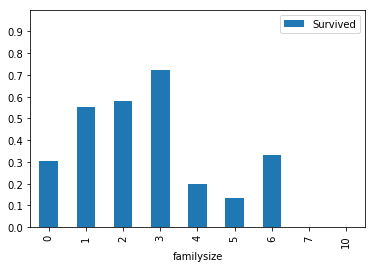

In [57]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()

explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)
pivot = explore.pivot_table(index=explore['familysize'],values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.show()

<b>This is also interesting, showing that once a family size hits 4 there is a big drop in survival rates</b>

In [58]:
no_parents_kids = train[train["Parch"]==0]
no_parents_kids["Survived"].describe()

count    678.000000
mean       0.343658
std        0.475279
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

In [59]:
parents_kids = train[train["Parch"]!=0]
parents_kids["Survived"].describe()

count    213.000000
mean       0.511737
std        0.501040
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

<b>More than 50% of those who travelled with parents OR children survived. Worth investigating further..</b>

In [60]:
sibling_spouse = train[train["SibSp"]!=0]
sibling_spouse["Survived"].describe()

count    283.000000
mean       0.466431
std        0.499756
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

In [61]:
no_sibling_spouse = train[train["SibSp"]==0]
no_sibling_spouse["Survived"].describe()

count    608.000000
mean       0.345395
std        0.475888
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

<h1>Feature Engineering</h1>

In [247]:
# based on the above investigations, create a function to add a flag if the passenger travelled alone, 
# and if under the age of one assume a nanny, and apply to both datasets

def family(df):
    
    df['isalone'] = np.where((df['SibSp']==0)&(df['Parch']==0),1,0)
    df['family_size'] = df['SibSp'] + df['Parch']
    df['big_family'] = np.where(df['family_size']>3,1,0)
    
    return df

train = family(train)
holdout = family(holdout)

In [248]:
# make an attempt to fill in the missing age data, since there is so much of it

def fill_missing_ages(df):
    
    df['Age_categories_Child'] = np.where((df['Age_categories_Missing']==1)&(df['Title']=="Master"),1,0)
    df['Age_categories_Child'] = np.where((df['Age_categories_Missing']==1)&(df['Title']=="Miss"),1,0)
    df['Age_categories_Adult'] = np.where((df['Age_categories_Missing']==1)&(df['Title']=="Mrs"),1,0)
    df['Age_categories_Adult'] = np.where((df['Age_categories_Missing']==1)&(df['Title']=="Mr"),1,0)
    
    return df

train = fill_missing_ages(train)
holdout = fill_missing_ages(holdout)
train.dtypes

PassengerId                  int64
Survived                     int64
Pclass                       int64
Name                        object
Sex                         object
Age                        float64
SibSp                        int64
Parch                        int64
Ticket                      object
Fare                       float64
Embarked                    object
Age_categories            category
Title                       object
Cabin_type                  object
Age_categories_Missing       uint8
Age_categories_Infant        uint8
Age_categories_Child         int64
Age_categories_Adult         int64
Age_categories_Senior        uint8
Title_Master                 uint8
Title_Miss                   uint8
Title_Mr                     uint8
Title_Mrs                    uint8
Title_Officer                uint8
Title_Royalty                uint8
Cabin_type_A                 uint8
Cabin_type_B                 uint8
Cabin_type_C                 uint8
Cabin_type_D        

<h1>Feature Selection</h1>

In [167]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [169]:
def select_features(df):
    
    # remove non numeric cols 
    drop_cols = ["Name", "Sex","Ticket","Embarked","Title","Cabin_type", "Age_categories","Fare_categories"]
    df = df.drop(drop_cols,axis=1)
        
    # remove any cols containing null values
    df = df.dropna(axis=1)
   
    all_X = df.drop(["PassengerId","Survived"], axis=1)
    all_y = df['Survived']
  
    # Use RFECV
    clf = RandomForestClassifier(random_state=1)

    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)

    optimized_columns = all_X.columns[selector.support_]

    return optimized_columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Fare_categories_12-50', 'Fare_categories_50-100', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Cabin_type_E', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male', 'isalone', 'family_size', 'big_family'],
      dtype='object')


In [170]:
features = select_features(train)
features

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Fare_categories_12-50', 'Fare_categories_50-100', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Cabin_type_E', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male', 'isalone', 'family_size', 'big_family'],
      dtype='object')


Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Fare_categories_12-50', 'Fare_categories_50-100', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Cabin_type_E', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male', 'isalone', 'family_size', 'big_family'],
      dtype='object')

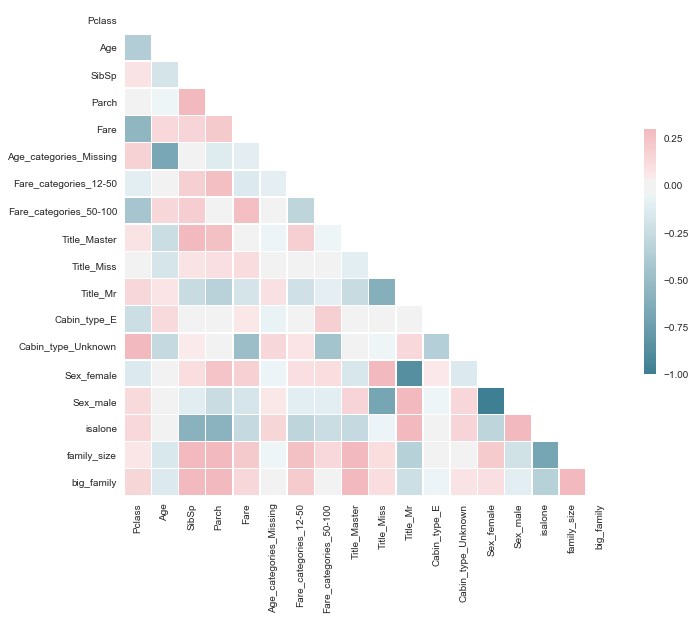

In [171]:
def plot_correlation_heatmap(df):
    
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

plot_correlation_heatmap(train[features])

<h1>Model Selection & Tuning</h1>

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

In [140]:
def select_model(df,features,target):
    
    all_X = df[features]
    all_y = df[target]
    
    model_list = [{"name":"LogisticRegression",
                     "estimator":LogisticRegression(),
                    "hyperparameters":{ "solver":["newton-cg", "lbfgs", "liblinear"]
                                        }
                    },
                    #{"name":"KNeighborsClassifier",
                    # "estimator":KNeighborsClassifier(),
                    #"hyperparameters":{ "n_neighbors": range(1,20,2),
                    #                    "weights": ["distance", "uniform"],
                    #                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                     #                   "p": [1,2]
                     #                   }
                   # },
                    {"name":"RandomForestClassifier",
                     "estimator":RandomForestClassifier(),
                    "hyperparameters":{ "n_estimators": [4, 6, 9],
                                        "criterion": ["entropy"],
                                        "max_depth": [2, 5, 10],
                                        "max_features": ["log2", "sqrt"],
                                        "min_samples_leaf": [1, 5, 8],
                                        "min_samples_split": [2, 3, 5]
                                        }
                     }]
    
        
    for model in model_list:
        
        print("Model name:",model["name"])
        model_instance = model["estimator"]
        grid = RandomizedSearchCV(model_instance,param_distributions=model["hyperparameters"],n_iter=2,cv=10)
        grid = GridSearchCV(model_instance,param_grid=model["hyperparameters"],cv=10)
        grid.fit(all_X,all_y)
        
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        print("Best score:",model["best_score"])
        model["best_estimator"] = grid.best_estimator_
        
    return model_list     

In [141]:
model_results = select_model(train,features,"Survived")

Model name: LogisticRegression
Best score: 0.822671156004
Model name: KNeighborsClassifier
Best score: 0.778900112233
Model name: RandomForestClassifier
Best score: 0.841750841751


In [142]:
# best score
best_score = max(model['best_score'] for model in model_results)
best_score

0.84175084175084181

In [143]:
# retrieve best estimator 
### From Stack Overflow, example of the above but retrieval of whole object
best_model = max(model_results, key=lambda x:x['best_score'])
estimator = best_model["best_estimator"]
estimator

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [185]:

clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#features = ['Pclass','Age','Fare', 'Sex_male', 'isalone', 'big_family']
            
#clf.fit(train[features], train['Survived'])
scores = cross_val_score(estimator, train[features], train['Survived'],cv=10)
print("Expected Score is",np.mean(scores))


Expected Score is 0.823890875043


<h3>Prepare Submission to Kaggle</h3>

In [71]:
def save_submission_file(model,df,columns,filename="Kaggle_Submission.csv"):
    
    predictions = model.predict(df[columns])
     
    ids = df["PassengerId"]
    submission_df = {"PassengerId":ids, "Survived": predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv(filename,index=False)


In [72]:
save_submission_file(estimator,holdout,features,"Submission_6.csv")